This code simulates the basic CA and prints the state after every step.


In [ ]:
! pip install pygame

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
import random

import pygame
import numpy as np
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Take on Step

In [ ]:
class State:
    def __init__(self, field_size, prey_population, predator_population, prey_death_rate, predator_death_rate, prey_birth_rate, predator_birth_rate):
        self.field_size = field_size
        self.prey_population = prey_population
        self.predator_population = predator_population
        self.field = self.init_field(field_size, prey_population, predator_population)
        self._prey_death_rate = prey_death_rate
        self._predator_death_rate = predator_death_rate
        self._prey_birth_rate = prey_birth_rate
        self._predator_birth_rate = predator_birth_rate

    def init_field(self, field_size, prey_population, predator_population):
        field = np.zeros((field_size, field_size))

        prey_location = np.random.choice(field_size*field_size, prey_population, replace=False)
        predator_location = np.random.choice(np.setdiff1d(np.arange(field_size*field_size), prey_location), predator_population, replace=False)

        prey_index = np.unravel_index(prey_location, (field_size, field_size))
        predator_index = np.unravel_index(predator_location, (field_size, field_size))

        field[prey_index] = 1
        field[predator_index] = 2

        return field

    def take_step(self):
        newField = np.array(self.field)

        for (x, y), element in np.ndenumerate(self.field):
            if element == 1:
                r = np.random.uniform(0, 1)
                predators_in_neighboorhood = self.count_target_moore(x,y,2)

                if not (r < (1-self._prey_death_rate)**predators_in_neighboorhood):
                    r = np.random.uniform(0, 1)
                    if r < self._predator_birth_rate:
                        newField[x,y] = 2
                        self.predator_population += 1
                        self.prey_population -= 1
            if element == 2:
                r = np.random.uniform(0, 1)
                if r < self._predator_death_rate:
                    newField[x,y] = 0
                    self.predator_population -= 1
            if element == 0:
                predators_in_neighboorhood = self.count_target_moore(x,y,2)
                preys_in_neighboorhood = self.count_target_moore(x,y,1)
                if preys_in_neighboorhood > 0 and predators_in_neighboorhood == 0:
                    r = np.random.uniform(0, 1)
                    if r < self._prey_birth_rate**preys_in_neighboorhood:
                        newField[x,y] = 1
                        self.prey_population += 1
        self.field = newField


    def count_target_moore(self, x, y, target):
        offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1),  (1, 0),  (1, 1)]
        count = 0

        for dr, dc in offsets:
            r_neighbor = x + dr
            c_neighbor = y + dc
            if r_neighbor >= self.field_size:
                r_neighbor = 0
            if r_neighbor < 0:
                r_neighbor = self.field_size - 1
            if c_neighbor >= self.field_size:
                c_neighbor = 0
            if c_neighbor < 0:
                c_neighbor = self.field_size - 1
            if self.field[r_neighbor, c_neighbor] == target:
                count += 1
        return count

# Simulation

In [ ]:
BLACK = (0, 0, 0)
WHITE = (200, 200, 200)
RED = (255, 0, 0)
GREEN = (0, 255, 0)

FIELD_SIZE = 3#25
#FIELD_SIZE = 35
FIELD_HEIGHT = FIELD_SIZE
FIELD_WIDTH = FIELD_SIZE
PREY_POPULATION = 6
PREDATOR_POPULATION = 3#66

# VISUALIZATION PARAMETERS
CELL_SIZE = 10 #Set the size of the grid block
WINDOW_HEIGHT = FIELD_HEIGHT * CELL_SIZE
WINDOW_WIDTH = FIELD_WIDTH * CELL_SIZE

def main(mode: str=None, **kwargs):
    global SCREEN, CLOCK
    prey_history = []
    predator_history = []
    pygame.init()
    SCREEN = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
    CLOCK = pygame.time.Clock()
    SCREEN.fill(BLACK)

    state = State(FIELD_SIZE,
                  PREY_POPULATION,
                  PREDATOR_POPULATION,
                  prey_death_rate=0.5,#0.03,#0.8, #beta
                  predator_death_rate=0.3,#3, #gamma
                  prey_birth_rate=0.7,#0.7, #alpha
                  predator_birth_rate=0.1)#0.5)#0.01)#0.6) #delta

    #state = State(FIELD_SIZE,
    #              100,
    #              20,
    #              prey_death_rate=0.03,
    #              predator_death_rate=0.1,
    #              prey_birth_rate=0.15,
    #              predator_birth_rate=0.01)

    #drawState(state)
    prey_history.append(state.prey_population)
    predator_history.append(state.predator_population)
    if mode == 'ONE-STEP':
        simulate_one_step(state, prey_history, predator_history)
    elif mode == 'WHILE':
        while True:
            simulate_one_step(state, prey_history, predator_history)
    elif mode == 'FOR':
        step_n = kwargs.get('step_n', 10)
        for i in range(step_n):
            simulate_one_step(state, prey_history, predator_history)

    return prey_history, predator_history

def simulate_one_step(state, prey_history, predator_history):
    # SOMEWHERE HERE SHOULD BE UPDATE STATE
    state.take_step()
    prey_history.append(state.prey_population)
    predator_history.append(state.predator_population)
    #print(state.field)
    drawState(state)
    pygame.display.update()


def drawState(state):
    # for x in range(0, WINDOW_WIDTH, CELL_SIZE):
    #     for y in range(0, WINDOW_HEIGHT, CELL_SIZE):
    for i in range(0, FIELD_WIDTH):
        x = i * CELL_SIZE
        for j in range(0, FIELD_HEIGHT):
          y = j * CELL_SIZE
          rect = pygame.Rect(x, y, CELL_SIZE, CELL_SIZE)

          # iterate by indexing
          if state.field[i][j] == 0:
              # just black cell, left as black screen
              pygame.draw.rect(SCREEN, BLACK, rect)
          elif state.field[i][j] == 1:
              # draw predator
              pygame.draw.rect(SCREEN, GREEN, rect)
          elif state.field[i][j] == 2:
              # draw prey
              pygame.draw.rect(SCREEN, RED, rect)
          else:
              raise Exception
              print('something wrong with state, some cell are not in {0, 1, 2}')

          # Draw white rectangle for the borders
          pygame.draw.rect(SCREEN, WHITE, rect, 1)


    pygame.display.flip()

    view = pygame.surfarray.array3d(SCREEN)

    #  convert from (width, height, channel) to (height, width, channel)
    #view = view.transpose([1, 0, 2])

    #  convert from rgb to bgr
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

    #Display image, clear cell every 0.5 seconds
    cv2_imshow(img_bgr)
    time.sleep(0.5)
    output.clear()

In [ ]:
prey_history, predator_history = main('FOR', step_n=200)

KeyboardInterrupt: 

# Visualization

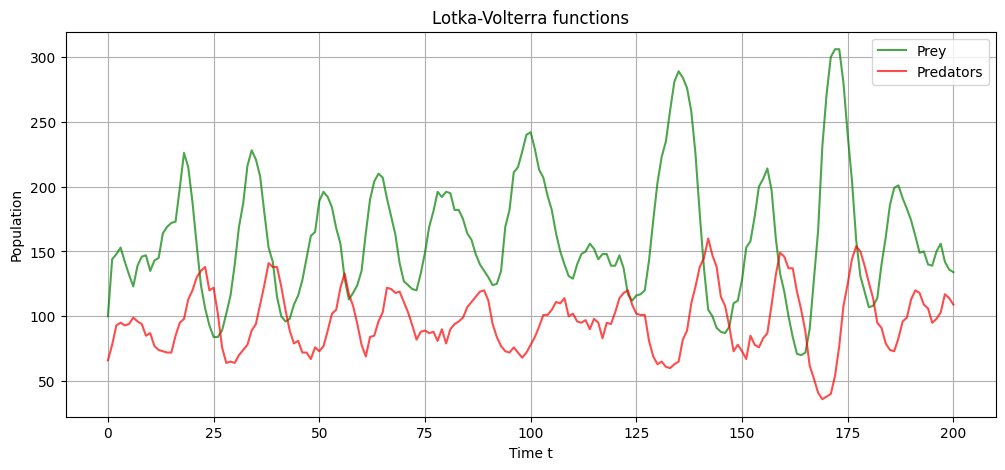

In [ ]:
plt.figure(figsize=(12,5))
plt.grid()
plt.title("Lotka-Volterra functions")
plt.plot(prey_history, 'g', label = 'Prey', alpha = 0.7)
plt.plot(predator_history, 'r', label = "Predators", alpha=0.7)
plt.xlabel('Time t')
plt.ylabel('Population')
plt.legend()
plt.show()

# Sandbox (not used Code)

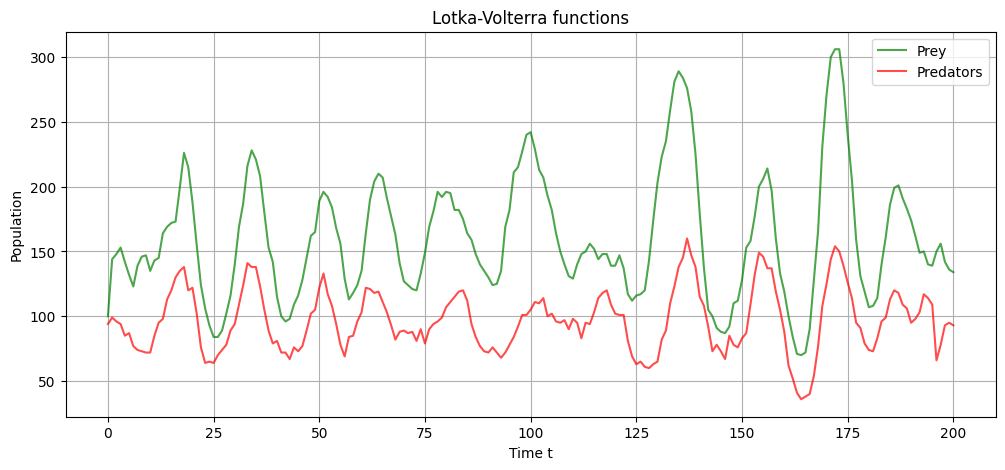

0.7762490554531453
-5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define function to perform cross-correlation analysis
def cross_correlation_analysis(ts1, ts2):
    # Calculate cross-correlation
    cross_corr = np.correlate(ts1, ts2, mode='full')

    # Find lag with maximum correlation
    max_corr_index = np.argmax(cross_corr)
    lag = max_corr_index - len(ts1) + 1  # Lag is relative to ts1

    # Calculate correlation coefficient
    correlation_coefficient = np.corrcoef(ts1, np.roll(ts2, lag))[0, 1]

    return lag, correlation_coefficient, cross_corr

# Perform cross-correlation analysis for each pair of time series
lag, correlation_coefficient, _ = cross_correlation_analysis(prey_history, predator_history)


plt.figure(figsize=(12,5))
plt.grid()
plt.title("Lotka-Volterra functions")
plt.plot(prey_history, 'g', label = 'Prey', alpha = 0.7)
plt.plot(np.roll(predator_history, lag), 'r', label = "Predators", alpha=0.7)
plt.xlabel('Time t')
plt.ylabel('Population')
plt.legend()
plt.show()

print(correlation_coefficient)
print(lag)